In [2]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet # To provide a best estimate of the encoding that was used in the text data
import io # For string operations
%matplotlib inline

# Libraries for data preparation and model building
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, TweetTokenizer, TreebankWordTokenizer
from nltk.corpus import stopwords
import string
import datetime
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import math
import re
from sklearn.utils import resample
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif, mutual_info_classif,chi2, VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from gensim.models import Word2Vec
import multiprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE,SMOTENC
from imblearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# LOAD DATASET

def transform_categorical_labels(data):
    # Dictionary mapping numerical categories to labels
    label_map = {
        2: 'News',
        1: 'Pro',
        0: 'Neutral',
        -1: 'Anti'
    }
    transformed_data = data.map(label_map)
    return transformed_data

def class_distribution(data):
    if isinstance(data, pd.DataFrame):
        unique_classes, class_counts = data.iloc[:, 0].value_counts().index, data.iloc[:, 0].value_counts().values
    elif isinstance(data, pd.Series):
        unique_classes, class_counts = data.value_counts().index, data.value_counts().values
    class_dict = dict(zip(unique_classes, class_counts))
    return class_dict

def load_dataset(environment, size, change_labels):
    if environment == 'colab':
        from google.colab import drive
        drive.mount('/content/drive')
        csv_file = '/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/data/train.csv'
    else:
        csv_file = r'G:\My Drive\Professionele ontwikkeling\Data Science\Explore Data Science Course\Sprint 6_Advanced Classification\Predict\advanced-classification-predict\data\train.csv'
    df = pd.read_csv(csv_file)
    if change_labels:
        df['sentiment'] = transform_categorical_labels(df['sentiment'])
    sample_size = int(len(df) * size)
    if size == 1:
        pass
    else:
        X = df.drop(columns=['sentiment']).copy()
        y = df.sentiment.copy()
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
        df = pd.concat([X_sample, y_sample], axis=1)
    class_dict = class_distribution(df['sentiment'])
    return df, class_dict


In [4]:
class NoiseRemover(BaseEstimator, TransformerMixin):
    def __init__(self, switch=None):
        self.switch = switch

    def fit(self, X, y):
        return self

    def transform(self, X, y=None):
        if self.switch == 'off':
            X_transformed = X
        elif self.switch == 'on':
            pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'   # Find all hyperlinks
            pattern_handle = r'@[A-Za-z0-9_]+'
            subs_url = r''
            subs_handle = r''
            X_transformed = pd.Series(X).replace(to_replace=pattern_url, value=subs_url, regex=True)
            X_transformed = X_transformed.replace(to_replace=pattern_handle, value=subs_handle, regex=True)
        else:
            raise ValueError("Invalid switch. Choose either 'on' or 'off'.")
        return X_transformed

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [5]:
class EmoticonConverter(BaseEstimator, TransformerMixin):
    def __init__(self, switch=None):
        self.switch = switch

    def fit(self, X, y):
        return self

    def transform(self, X, y=None):
        if self.switch == 'off':
            X_transformed = X
        elif self.switch == 'on':
            emoticon_dictionary = {':\)': 'smiley_face_emoticon',
                                   ':\(': 'frowning_face_emoticon',
                                   ':D': 'grinning_face_emoticon',
                                   ':P': 'sticking_out_tongue_emoticon',
                                   ';\)': 'winking_face_emoticon',
                                   ':o': 'surprised_face_emoticon',
                                   ':\|': 'neutral_face_emoticon',
                                   ':\'\)': 'tears_of_joy_emoticon',
                                   ':\'\(': 'crying_face_emoticon'}
            X_transformed = X.replace(emoticon_dictionary, regex=True)
        else:
            raise ValueError("Invalid switch. Choose either 'on' or 'off'.")
        return X_transformed

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [6]:
class PunctuationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, switch=None):
        self.switch = switch

    def fit(self, X, y):
        return self

    def transform(self, X, y=None):
        def expand_contractions(text):
            contractions = {"'t": " not","'s": " is","'re": " are","'ll": " will", "'m": " am"}
            pattern = re.compile(r"\b(" + "|".join(re.escape(key) for key in contractions.keys()) + r")\b")
            text = re.sub(r"n't\b", " not", text) # Replace "n't" with " not"
            text = pattern.sub(lambda match: contractions[match.group(0)], text) # Replace all other contractions except for "n't"
            return text

        def remove_punctuation(text):
            return ''.join([l.lower() for l in text if l not in string.punctuation])

        if self.switch == 'off':
            X_transformed = X
        elif self.switch == 'on':
            X_transformed = X.apply(lambda x: expand_contractions(x))
            X_transformed = X_transformed.apply(lambda x: remove_punctuation(x))
        else:
            raise ValueError("Invalid switch. Choose either 'on' or 'off'.")
        return X_transformed

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [7]:
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, type=None):
        self.type = type

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.type == 'TweetTokenizer':
            tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)
        elif self.type == 'TreebankWordTokenizer':
            tokenizer = TreebankWordTokenizer()
        else:
            raise ValueError("Invalid tokenizer type. Choose either 'TweetTokenizer' or 'TreebankWordTokenizer'")
        X_transformed = X.apply(tokenizer.tokenize)
        return X_transformed

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [8]:
class GarbageRemover(BaseEstimator, TransformerMixin):
    def __init__(self, switch=None):
        self.switch = switch
        self.pattern = re.compile(r'^[a-zA-Z\U0001F300-\U0001FAD6\U0001F004-\U0001F251]*[^a-zA-Z\U0001F300-\U0001FAD6\U0001F004-\U0001F251]+[a-zA-Z\U0001F300-\U0001FAD6\U0001F004-\U0001F251]*$')
    def is_garbage(self, word):
        """
        Define a regular expression pattern to match garbage words
        Garbage is defined as words starting with anything but a letter, or
        words containing strange characters.  Emojis are not considered garbage
        """
        return bool(self.pattern.match(word))

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.switch == 'off':
            return X
        elif self.switch == 'on':
            transformed_words = [[word for word in word_list if not self.is_garbage(word)] or ['blankpost'] for word_list in X]
            return pd.Series(transformed_words)
        else:
            raise ValueError("Invalid switch. Choose either 'on' or 'off'.")

    def fit_transform(self, X, y=None):
        if self.switch == 'off':
            return X
        elif self.switch == 'on':
            self.fit(X, y)
            return self.transform(X, y)
        else:
            raise ValueError("Invalid switch. Choose either 'on' or 'off'.")

In [9]:
class StopwordRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.apply(lambda tokens: [t for t in tokens if t.lower() not in self.stop_words])
        return X_transformed

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [10]:
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, pos=None):
        self.pos = pos

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.pos not in ['v','n', 'a', 'r']:
            raise ValueError('Invalid pos type. Choose either a, n, r or v')
        else:
            lemmatizer = WordNetLemmatizer()
            X_transformed = X.apply(lambda tokens: [lemmatizer.lemmatize(word, pos=self.pos) for word in tokens])
        return X_transformed

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [11]:
class Vectorize(BaseEstimator, TransformerMixin):
    def __init__(self, type=None, max_df=None, min_df=None, ngram_range=None, max_features=None):
        self.type = type
        self.max_df = max_df
        self.min_df = min_df
        self.ngram_range = ngram_range
        self.max_features = max_features

    def fit(self, X, y=None):
        if self.type == 'count':
            self.vectorizer = CountVectorizer(max_features=self.max_features, lowercase=True,
                                              max_df=self.max_df, min_df=self.min_df,
                                              ngram_range=self.ngram_range)
        elif self.type == 'tfidf':
            self.vectorizer = TfidfVectorizer(max_features=self.max_features, lowercase=True,
                                              max_df=self.max_df, min_df=self.min_df,
                                              ngram_range=self.ngram_range)
        else:
            raise ValueError("Invalid vectorizer type. Choose either 'count' or 'tfidf'")

        X_joined = [' '.join(tokens) for tokens in X]
        self.vectorizer.fit(X_joined)
        return self.vectorizer.fit(X_joined)

    def transform(self, X, y=None):
        X_joined = [' '.join(tokens) for tokens in X]
        return self.vectorizer.transform(X_joined)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [12]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, type=None, percentile=None,threshold=None):
        self.type = type
        self.percentile = percentile
        self.threshold = threshold

    def fit(self, X, y=None):
        if self.type == 'chi2':
            self.selector = SelectPercentile(score_func=chi2, percentile=self.percentile)
        elif self.type == 'anova_f':
            self.selector = SelectPercentile(score_func=f_classif, percentile=self.percentile)
        elif self.type == 'variance_threshold':
            self.selector = VarianceThreshold(threshold=self.threshold)
        else:
            raise ValueError("Invalid selector type. Choose between 'chi2','anova_f' or 'variance_threshold'.")
        self.selector.fit(X, y)
        return self

    def transform(self, X, y=None):
        return self.selector.transform(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [13]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, type=None):
        self.type = type
        self.scaler = None

    def fit(self, X, y=None):
        if self.type == 'none':
            return self
        else:
            if self.type == 'robust':
                self.scaler = RobustScaler(with_centering=False)
            elif self.type == 'maxabs':
                self.scaler = MaxAbsScaler()
            elif self.type == 'standard':
                self.scaler = StandardScaler(with_mean=False)
            else:
                raise ValueError("Invalid scaler type. Choose between 'none, 'standard', 'robust' or 'maxabs'.")
            return  self.scaler.fit(X)

    def transform(self, X, y=None):
        if self.type == 'none':
            return X
        else:
            return self.scaler.transform(X)

    def fit_transform(self, X, y=None):
        if self.type == 'none':
            return X
        else:
            self.fit(X, y)
            return self.transform(X, y)

In [14]:
# Set the size of the sample to load (to reduce runtime for gridsearch)
size = 0.2
change_labels = True
df_train, class_dictionary = load_dataset('colab',size,change_labels=change_labels)
# Next section is to calculate class imbalance, for use in randomover and randomundersampling
#number_classes = len(class_dictionary)
#majority = max(class_dictionary.values())
#average_class_count = int(size / number_classes)
#oversampling_strategy = {key: max(average_class_count, count)  for key, count in class_dictionary.items()}
#undersampling_strategy = {key: average_class_count  for key, count in oversampling_strategy.items()}
df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,message,tweetid,sentiment
7669,RT @Mrfarrago: “catastrophic man-made global w...,753059,Anti
15577,"In executive order, Trump to dramatically chan...",24585,News
14132,The U.S. public is largely skeptical of climat...,916197,News
3116,Roses you carnation pink All global warming re...,353744,Neutral
5074,RT @StephenSchlegel: she's thinking about how ...,465734,Pro


In [ ]:
# Gridsearch on pipeline (one model only)

X_train, X_test, y_train, y_test = train_test_split(df_train['message'], df_train['sentiment'], test_size=0.2, random_state=42, stratify=df_train['sentiment'])

# Defining preprocessing steps
preprocessing_steps = [
    ('noise_removal', NoiseRemover()),
    ('emoticon_convertion', EmoticonConverter()),
    ('punctuation_removal', PunctuationRemover()),
    ('tokenization', Tokenizer()),
    ('garbageout', GarbageRemover()),
    ('stopword_removal', StopwordRemover()),
    ('lemmatization', Lemmatizer()),
    ('vectorization', Vectorize()),
    #('oversampler', RandomOverSampler(sampling_strategy=oversampling_strategy, random_state=42)),
    #('undersampler', RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)),
    ('smote', SMOTE()),
    ('feature_selection', FeatureSelector()),
    ('scaler', Scaler()),
]

# Create the pipelines
model = SVC()
model_name = 'SVC RBF'
pipeline = Pipeline(preprocessing_steps  + [('model', model)])

# Define parameter grid for GridSearchCV
param_grid = {
    # Parameters for the custom transformers
    'noise_removal__switch': ['off'],#'on'],
    'emoticon_convertion__switch': ['off'],#,'on'],
    'punctuation_removal__switch':  ['off'],#,'on'],
    'tokenization__type': ['TreebankWordTokenizer'],#'TweetTokenizer'],
    'garbageout__switch': ['off'],#,'on'],
    'lemmatization__pos': ['v'],#,'n','a','r'],
    'vectorization__type': ['tfidf'],#,'count'],
    'vectorization__max_df': [0.75],#
    'vectorization__min_df': [1],#, 2],
    'vectorization__ngram_range': [(1,1)],# (1, 10)],
    'vectorization__max_features': [None],
    'smote__k_neighbors': [3],
    'smote__random_state': [42],
    'feature_selection__percentile': [75],#,25],
    'feature_selection__type': ['chi2'],#'variance_threshold'],
    'feature_selection__threshold': [0.001],
    #'feature_selection__percentage': [0.10, 0.75],
    'scaler__type': ['robust'],  # 'none','maxabs'],

    # Hyperparameters for the model
    #'model__n_neighbors': [3,4,5],                                #KNN
    #'model__weights': [ 'distance','uniform'],               #KNN
    #'model__metric': ['euclidean', 'manhattan'],            #KNN
    'model__kernel': ['linear'],                             #SVM RBF
    'model__C': [1],#,2],#,10,1],                                  #SVM RBF
    'model__gamma': [1],#,2],# 0.1]                                 #SVM RBF
    'model__tol': [0.00001],# 0.1]                                 #SVM RBF
    'model__random_state': [42],                                    #SVM RBF
    'model__shrinking': [True],                                    #SVM RBF
    #'model__degree': [2],#,3],                                    #SVM RBF
    #'model__penalty': ['l2'],#,'l1'],                            #LogisticRegression
    #'model__C': [7],#,100,1,0.001,0.1,],                             #LogisticRegression
    #'model__solver': ['liblinear'],#['sag']                     #LogisticRegression
    #'model__multi_class': ['ovr'],#'multinomial',               #LogisticRegression
    #'model__max_iter': [100000],                               #LogisticRegression
    #'model__tol': [0.0001],#, 0.0001],                                #LogisticRegression
    #'model__random_state': [42],                                     #LogisticRegression
    #'model__alpha': [0.1],#3, 0.5,],# 0.1,1,5,10],                               #Multinomial NB
    #'model__fit_prior': [True],# False],                               #Multinomial NB
    #'model__n_estimators': [300],                              #Adaboost
    #'model__learning_rate': [0.01],#, 1, 5],                              #Adaboost
    #'model__random_state': [42],                                     #Adaboost
    #'model__algorithm': ['SAMME'],                                    #Adaboost
    #'model__estimator': [LogisticRegression(C=10, max_iter=10000,multi_class='ovr', solver='liblinear', tol=0.0001, penalty='l2', random_state=42)] #,SVC(kernel='rbf', C=100,gamma=0.1)],DecisionTreeClassifier(), ],   #Adaboost
}
# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', error_score='raise', verbose=2)
grid_search.fit(X_train, y_train)
df_gridsearch = pd.DataFrame(grid_search.cv_results_)
print(grid_search.best_score_)
print(grid_search.best_params_)

selected_columns = ['Model','Dataset','Timestamp','mean_fit_time','mean_score_time','change_labels','params','split0_test_score','split1_test_score',
                    'split2_test_score','split3_test_score','split4_test_score',
                    'std_test_score','mean_test_score']

#Create blank results dataframe - only do this once
###results_df = pd.DataFrame(columns=selected_columns)
###results_df.to_csv('/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/notebook/Model results.csv', index=False)
new_data = pd.DataFrame(columns=selected_columns)
new_data[['mean_fit_time','mean_score_time','params','split0_test_score','split1_test_score',
         'split2_test_score','split3_test_score','split4_test_score',
          'std_test_score','mean_test_score']] = df_gridsearch[['mean_fit_time',
         'mean_score_time','params','split0_test_score','split1_test_score',
         'split2_test_score','split3_test_score','split4_test_score',
         'std_test_score','mean_test_score']]
new_data['Model'] = model_name
new_data['Dataset'] = size
new_data['Timestamp']= datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
new_data['change_labels'] = change_labels
new_data.to_csv('/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/notebook/Model results.csv', mode='a', header=False, index=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Shape after Scaler: (4368, 5296)
Shape after Scaler: (506, 5296)
[CV] END emoticon_convertion__switch=off, feature_selection__percentile=75, feature_selection__threshold=0.001, feature_selection__type=chi2, garbageout__switch=off, lemmatization__pos=v, model__C=1, model__gamma=1, model__kernel=linear, model__random_state=42, model__shrinking=True, model__tol=1e-05, noise_removal__switch=off, punctuation_removal__switch=off, scaler__type=robust, smote__k_neighbors=3, smote__random_state=42, tokenization__type=TreebankWordTokenizer, vectorization__max_df=0.75, vectorization__max_features=None, vectorization__min_df=1, vectorization__ngram_range=(1, 1), vectorization__type=tfidf; total time=  18.6s
Shape after Scaler: (4368, 5238)
Shape after Scaler: (506, 5238)
[CV] END emoticon_convertion__switch=off, feature_selection__percentile=75, feature_selection__threshold=0.001, feature_selection__type=chi2, garbageout__switch=off, lemma

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/6
11/11 [==============================] - 16s 1s/step - loss: 1.3171 - accuracy: 0.6142 - val_loss: 1.2283 - val_accuracy: 0.5499
Epoch 2/6
11/11 [==============================] - 14s 1s/step - loss: 0.9693 - accuracy: 0.7924 - val_loss: 0.9651 - val_accuracy: 0.6271
Epoch 3/6
11/11 [==============================] - 13s 1s/step - loss: 0.5209 - accuracy: 0.8956 - val_loss: 0.7590 - val_accuracy: 0.7016
Epoch 4/6
11/11 [==============================] - 13s 1s/step - loss: 0.2385 - accuracy: 0.9570 - val_loss: 0.6988 - val_accuracy: 0.7317
Epoch 5/6
11/11 [==============================] - 15s 1s/step - loss: 0.1157 - accuracy: 0.9795 - val_loss: 0.7432 - val_accuracy: 0.7345
Epoch 6/6
11/11 [==============================] - 13s 1s/step - loss: 0.0639 - accuracy: 0.9886 - val_loss: 0.8006 - val_accuracy: 0.7355


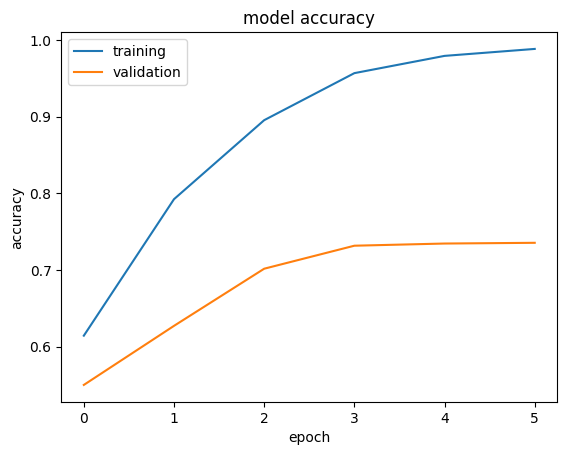

Test loss: 0.801
Test accuracy: 0.735


In [ ]:
# Attempt a neural network

size = 1
change_labels = False
df_train, class_dictionary = load_dataset('colab',size,change_labels=change_labels)
X_train, X_test, y_train, y_test = train_test_split(df_train['message'], df_train['sentiment'], test_size=0.2, random_state=42, stratify=df_train['sentiment'])

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from matplotlib import pyplot as plt
from random import randint
from tensorflow.keras.utils import to_categorical
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score

# Transform data with all preprocessing steps
noise = NoiseRemover(switch='off')
X_train = noise.fit_transform(X_train, y_train)
X_test = noise.transform(X_test, y_test)
emoti = EmoticonConverter(switch='off')
X_train = emoti.fit_transform(X_train, y_train)
X_test = emoti.transform(X_test, y_test)
punct = PunctuationRemover(switch='off')
X_train = punct.fit_transform(X_train, y_train)
X_test = punct.transform(X_test, y_test)
token = Tokenizer(type='TreebankWordTokenizer')
X_train = token.fit_transform(X_train, y_train)
X_test = token.transform(X_test, y_test)
garbage = GarbageRemover(switch='off')
X_train = garbage.fit_transform(X_train, y_train)
X_test = garbage.transform(X_test, y_test)
stop = StopwordRemover()
X_train = stop.fit_transform(X_train, y_train)
X_test = stop.transform(X_test, y_test)
lemma = Lemmatizer(pos='v')
X_train = lemma.fit_transform(X_train, y_train)
X_test = lemma.transform(X_test, y_test)
vect = Vectorize(max_df=0.75, max_features=None, min_df=1,ngram_range=(1, 1),type='tfidf')
X_train = vect.fit_transform(X_train, y_train)
X_test = vect.transform(X_test, y_test)
smote = SMOTE(k_neighbors=3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
feat = FeatureSelector(type='chi2',percentile=75)
X_train = feat.fit_transform(X_train, y_train)
X_test = feat.transform(X_test, y_test)
scale = Scaler(type='robust')
X_train = scale.fit_transform(X_train, y_train)
X_test = scale.transform(X_test, y_test)
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Convert sparse matrix to dense numpy array
X_train = X_train.toarray()
X_test = X_test.toarray()

# Create and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu' ),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(
  optimizer='nadam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=6, batch_size=2500)

loss, accuracy  = model.evaluate(X_test, y_test, verbose=False)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# 1. Evaluate the F1 Score
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)
f1_train = f1_score(y_train_true_classes, y_pred_train_classes, average='macro')
f1_test = f1_score(y_test_true_classes, y_pred_test_classes, average='macro')

print(f'Training F1 Score: {f1_train:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')



In [ ]:
# MODEL COMPARISONS

# Load the data
label_change = True
size = 0.2
df_train, _ = load_dataset('colab',size,change_labels=label_change)
X_train, X_test, y_train, y_test = train_test_split(df_train['message'], df_train['sentiment'], test_size=0.2, random_state=42, stratify=df_train['sentiment'])

# Set common preprocessing parameters to include in GridSearch
preprocessing_params = {
    'noise_removal__switch': ['off'],#'on'],
    'emoticon_convertion__switch': ['off'],#,'on'],
    'punctuation_removal__switch':  ['off'],#,'on'],
    'tokenization__type': ['TreebankWordTokenizer'],#'TweetTokenizer'],
    'garbageout__switch': ['off'],#,'on'],
    'lemmatization__pos': ['v'],#,'n','a','r'],
    'vectorization__type': ['tfidf'],#,'count'],
    'vectorization__max_df': [0.75],#
    'vectorization__min_df': [1],#, 2],
    'vectorization__ngram_range': [(1,1)],# (1, 10)],
    'vectorization__max_features': [None],
    'smote__k_neighbors': [3],
    'smote__random_state': [42],
    'feature_selection__percentile': [75],#,25],
    'feature_selection__type': ['chi2'],#'variance_threshold'],
    'feature_selection__threshold': [0.001],
    #'feature_selection__percentage': [0.10, 0.75],
    'scaler__type': ['robust'],  # 'none','maxabs'],
}

# Define the pipeline
pipeline = Pipeline([
    ('noise_removal', NoiseRemover()),
    ('emoticon_convertion', EmoticonConverter()),
    ('punctuation_removal', PunctuationRemover()),
    ('tokenization', Tokenizer()),
    ('garbageout', GarbageRemover()),
    ('stopword_removal', StopwordRemover()),
    ('lemmatization', Lemmatizer()),
    ('vectorization', Vectorize()),
    #('oversampler', RandomOverSampler(sampling_strategy=oversampling_strategy, random_state=42)),
    #('undersampler', RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)),
    ('smote', SMOTE()),
    ('feature_selection', FeatureSelector()),
    ('scaler', Scaler()),
    ('model', None) #Placeholder for the model to be used
])

# Define the various models and their hyperpameters to include in Gridsearch
model_params = {
    'Multinomial Naive Bayes': {
        **preprocessing_params,
        'model': [MultinomialNB()],
        'model__alpha': [0.1],
        'model__fit_prior': [True]
    },
    'LogisticRegression': {
        **preprocessing_params,
        'model': [LogisticRegression()],
        'model__penalty': ['l2'],
        'model__C': [7],
        'model__solver': ['liblinear'],
        'model__multi_class': ['ovr'],
        'model__max_iter': [1000000],
        'model__tol': [0.00001],
        'model__random_state': [42]
    },
    'SVC': {
        **preprocessing_params,
        'model': [SVC()],
        'model__kernel': ['linear'],
        'model__C': [0.025]
    },
    'Adaboost': {
        **preprocessing_params,
        'model': [AdaBoostClassifier()],
        'model__n_estimators': [100,200],
        'model__learning_rate': [0.01, 0.5]
    }
}

for model_name, param_grid in model_params.items():
    print(f"Training {model_name}...")
    # Update the pipeline with the classifier
    pipeline.set_params(model=None)  # Reset the classifier
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', error_score='raise', verbose=2)
    grid_search.fit(X_train, y_train)
    df_gridsearch = pd.DataFrame(grid_search.cv_results_)
    # Write to CSV file
    selected_columns = ['Model','Dataset','Timestamp','mean_fit_time','mean_score_time','change_labels','params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','std_test_score','mean_test_score']
    #Create blank results dataframe - only do this once
    #results_df = pd.DataFrame(columns=selected_columns)
    #results_df.to_csv('/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/notebook/Model_Comparison results.csv', index=False)
    new_data = pd.DataFrame(columns=selected_columns)
    new_data[['mean_fit_time','mean_score_time','params','split0_test_score','split1_test_score',
         'split2_test_score','split3_test_score','split4_test_score','std_test_score','mean_test_score']] = df_gridsearch[['mean_fit_time',
         'mean_score_time','params','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','std_test_score','mean_test_score']]
    new_data['Model'] = model_name
    new_data['Dataset'] = size
    new_data['Timestamp']= datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    new_data['change_labels'] = label_change
    new_data.to_csv('/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/notebook/Model_Comparison results.csv', mode='a', header=False, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Multinomial Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END emoticon_convertion__switch=off, feature_selection__percentile=75, feature_selection__threshold=0.001, feature_selection__type=chi2, garbageout__switch=off, lemmatization__pos=v, model=MultinomialNB(), model__alpha=0.1, model__fit_prior=True, noise_removal__switch=off, punctuation_removal__switch=off, scaler__type=robust, smote__k_neighbors=3, smote__random_state=42, tokenization__type=TreebankWordTokenizer, vectorization__max_df=0.75, vectorization__max_features=None, vectorization__min_df=1, vectorization__ngram_range=(1, 1), vectorization__type=tfidf; total time=   1.7s
[CV] END emoticon_convertion__switch=off, feature_selection__percentile=75, feature_selection__threshold=0.001, feature_selection__type=chi2, garbageout__switch=off, lemmatization__pos=v,

In [ ]:
# Train model on 100% of the data

df_train, _ = load_dataset('colab',1,change_labels=True)
X_train, X_test, y_train, y_test = train_test_split(df_train['message'], df_train['sentiment'], test_size=0.2, random_state=42)#, stratify=df_train['sentiment'])
preprocessing_steps = [
                       ('noise_removal', NoiseRemover(switch='off')),
                       ('emoticon_convertion', EmoticonConverter(switch='off')),
                       ('punctuation_removal', PunctuationRemover(switch='off')),
                       ('tokenization', Tokenizer(type='TreebankWordTokenizer')),
                       ('garbageout', GarbageRemover(switch='off')),
                       ('stopword_removal', StopwordRemover()),
                       ('lemmatization', Lemmatizer(pos='v')),
                       ('vectorization', Vectorize(max_df=0.75, max_features=None,
                                                   min_df=1,ngram_range=(1, 1),type='tfidf')),
                       ('smote', SMOTE(k_neighbors=3, random_state=42)),
                       ('feature_selection', FeatureSelector(type='chi2',percentile=75)),
                       ('scaler', Scaler(type='robust')),
                       ]
model = SVC(C=1, gamma=1, kernel ='linear', random_state=42, shrinking=True, tol=1e-05)
#model = LogisticRegression(C=10, max_iter=100000,multi_class='ovr', solver='liblinear', tol=0.0001, penalty='l2', random_state=42)
pipeline = Pipeline(preprocessing_steps  + [('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report for test set:")
print(report)
print('************************')

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
predictions = cross_val_predict(pipeline, X_train, y_train, cv=k_fold)
report = classification_report(y_train, predictions)
print("Classification Report for CV:\n", report)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape after Scaler: (27100, 19296)
Shape after Scaler: (3164, 19296)
Classification Report for test set:
              precision    recall  f1-score   support

        Anti       0.63      0.55      0.58       278
     Neutral       0.47      0.45      0.46       425
        News       0.66      0.83      0.73       706
         Pro       0.81      0.75      0.78      1755

    accuracy                           0.71      3164
   macro avg       0.64      0.64      0.64      3164
weighted avg       0.71      0.71      0.71      3164

************************
Shape after Scaler: (21636, 16455)


In [ ]:
'''
# Evaluate the pipeline
accuracy = pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

model_stats = pipeline.named_steps['model']

# Obtain the number of features used by the model
attributes = model_stats.__dict__

# Print all attributes
for attr, value in attributes.items():
    print(attr, ":", value)
'''

In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'G:/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/notebook/dawieloots_predict_gridsearch_{timestamp}.csv'
df_gridsearch.to_csv(filename, index=False)

In [ ]:

print(df_gridsearch)
print(grid_search.get_params)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Custom transformer to wrap SMOTE

class ResampleAndFeatureSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=1000, score_func=chi2, k_neighbors=5):
        self.k = k
        self.score_func = score_func
        self.k_neighbors = k_neighbors
        self.feature_selector = SelectKBest(score_func=self.score_func, k=self.k)
        
    def fit(self, X, y):
        # Print the shape of X_train before preprocessing
               
        # Select features from the resampled data
        self.feature_selector.fit(X, y)
        
        # Print the shape of X_train after preprocessing
        
        return self

    def transform(self, X):
        # Select features from the input data
        X_selected = self.feature_selector.transform(X)
        return X_selected

# Load the 20 Newsgroups dataset
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
data_subset = {
    'data': data.data[:1000],
    'target': data.target[:1000],
    'target_names': data.target_names
}

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_subset['data'], data_subset['target'], test_size=0.2, random_state=42)

# Define preprocessing steps
preprocessing_steps = [
    # Text preprocessing
    ('vectorizer', TfidfVectorizer()),  # Convert text data into numerical vectors
    ('smote', SMOTE()),
    ('resample_and_feature_select', ResampleAndFeatureSelectTransformer(k=1000, score_func=chi2)),  # Resample and select top k features
    
]

# Define the model
model = KNeighborsClassifier()

# Create the pipeline
pipeline = Pipeline(preprocessing_steps + [('model', model)])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
accuracy = pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

model = pipeline.named_steps['model']

# Obtain the number of features used by the model
attributes = model.__dict__

# Print all attributes
for attr, value in attributes.items():
    print(attr, ":", value)
#n_features = model.n_features_
#print("Number of features used by the model:", n_features)


In [ ]:
## Final model building with full trainset
df_train, _  = load_dataset('colab',1,change_labels=True)
X_train = df_train['message']
y_train = df_train['sentiment']

preprocessing_steps =  [
                       ('noise_removal', NoiseRemover(switch='off')),
                       ('emoticon_convertion', EmoticonConverter(switch='off')),
                       ('punctuation_removal', PunctuationRemover(switch='off')),
                       ('tokenization', Tokenizer(type='TreebankWordTokenizer')),
                       ('garbageout', GarbageRemover(switch='off')),
                       ('stopword_removal', StopwordRemover()),
                       ('lemmatization', Lemmatizer(pos='v')),
                       ('vectorization', Vectorize(max_df=0.75, max_features=None,
                                                   min_df=1,ngram_range=(1, 1),type='tfidf')),
                       ('smote', SMOTE(k_neighbors=3, random_state=42)),
                       ('feature_selection', FeatureSelector(percentile=75, type='chi2')),
                       ('scaler', Scaler(type='robust')),
                       ]

#model = LogisticRegression(C=10, max_iter=10000,multi_class='ovr', solver='liblinear', tol=0.0001, penalty='l2', random_state=42)
model = SVC(C=1, gamma=1, kernel ='linear', random_state=42, shrinking=True, tol=1e-05)
pipeline = Pipeline(preprocessing_steps  + [('model', model)])
pipeline.fit(X_train, y_train)

In [ ]:
model_stats = pipeline.named_steps['model']

# Obtain the number of features used by the model
attributes = model_stats.__dict__

# Print all attributes
for attr, value in attributes.items():
    print(attr, ":", value)

In [ ]:
test_file = '/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/data/test_with_no_labels.csv'
df_test = pd.read_csv(test_file)
X_unseen = df_test['message']

# Predict
y_pred_text = pipeline.predict(X_unseen)
label_map = {
        'News': 2,
        'Pro': 1,
        'Neutral': 0,
        'Anti': -1
    }
y_pred_int = [label_map[label] for label in y_pred_text]
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'/content/drive/MyDrive/Professionele ontwikkeling/Data Science/Explore Data Science Course/Sprint 6_Advanced Classification/Predict/advanced-classification-predict/notebook/dawieloots_predict_{timestamp}.csv'
submission_df = pd.DataFrame()
submission_df['tweetid'] = df_test.tweetid
submission_df['sentiment'] = y_pred_int
submission_df.to_csv(filename, index=False)

In [ ]:
submission_df.head()